In [1]:
import keras
keras.__version__
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.
C:\Users\jimli\.conda\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jimli\.conda\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jimli\.conda\envs\deep_learning\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jimli\.conda\envs\deep_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#base_dir = '/content/clouderizer/enhancecnn_enhance_20190731/code/cats_and_dogs_small'
base_dir = '/content/CNN_Enhancement_20190806/cats_and_dogs_small'
#base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [4]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

W0806 09:31:11.133652 17272 deprecation.py:506] From C:\Users\jimli\.conda\envs\deep_learning\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0806 09:31:11.199474 17272 deprecation_wrapper.py:119] From C:\Users\jimli\.conda\envs\deep_learning\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 09:31:11.267293 17272 deprecation.py:323] From C:\Users\jimli\.conda\envs\deep_learning\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.w

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5954 - acc: 0.6715 - val_loss: 0.4299 - val_acc: 0.8420
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4166 - acc: 0.8055 - val_loss: 0.3532 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3496 - acc: 0.8545 - val_loss: 0.3112 - val_acc: 0.8800
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3070 - acc: 0.8730 - val_loss: 0.3026 - val_acc: 0.8730
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2804 - acc: 0.8860 - val_loss: 0.2762 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2602 - acc: 0.8985 - val_loss: 0.2810 - val_acc: 0.8840
Epoch 7/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2367 - acc: 0.9070 - val_loss: 0.2612 - val_acc: 0.8920
Epoch 8/30
200

In [5]:
model.save('Using_VGG_Pretrain_Feature_Extraction_20190731.h5')

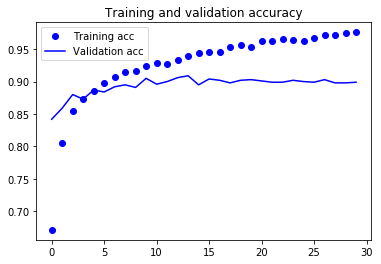

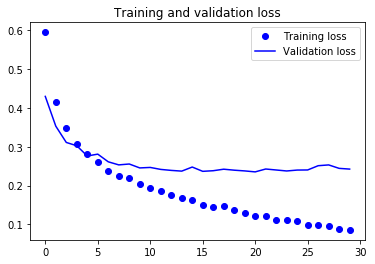

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
# Directories for our training,validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [21]:
from keras.models import load_model
model = load_model ('Using_VGG_Pretrain_Feature_Extraction_20190731.h5')

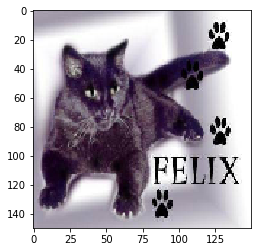

ValueError: Error when checking input: expected dense_1_input to have 2 dimensions, but got array with shape (1, 150, 150, 3)

In [33]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
fnames = [os.path.join(test_cats_dir, fname) for fname in os.listdir(test_cats_dir)]
count = 0
for i in range (1, 30):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.show()
    # Convert it to a Numpy array with shape (150, 150, 3)
    image_tensor = image.img_to_array(img)
    image_tensor = np.expand_dims(image_tensor,axis=0)
    image_tensor /= 255.
    #image_tensor = preprocess_input(image_tensor)
    prob = model.predict(image_tensor)
    #prob = model.predict(img)
    print(prob)
    if (prob < 0.3) :
        count = count + 1
print("corrected identified count = ", count)    

In [34]:
import keras
keras.__version__


'2.2.4'

In [35]:
from keras import models
from keras import layers
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [37]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [38]:
conv_base.trainable = False

In [39]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [40]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#base_dir = '/content/clouderizer/enhancecnn_enhance_20190731/code/cats_and_dogs_small'
base_dir = '/content/CNN_Enhancement_20190806/cats_and_dogs_small'
#base_dir = './cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 207s - loss: 0.6037 - acc: 0.6825 - val_loss: 0.4823 - val_acc: 0.7960
Epoch 2/30
 - 202s - loss: 0.4969 - acc: 0.7780 - val_loss: 0.3913 - val_acc: 0.8380
Epoch 3/30
 - 204s - loss: 0.4382 - acc: 0.8025 - val_loss: 0.3416 - val_acc: 0.8590
Epoch 4/30
 - 206s - loss: 0.4111 - acc: 0.8190 - val_loss: 0.3144 - val_acc: 0.8640
Epoch 5/30
 - 212s - loss: 0.3841 - acc: 0.8390 - val_loss: 0.3151 - val_acc: 0.8580
Epoch 6/30
 - 212s - loss: 0.3747 - acc: 0.8310 - val_loss: 0.2884 - val_acc: 0.8740
Epoch 7/30
 - 225s - loss: 0.3656 - acc: 0.8420 - val_loss: 0.2793 - val_acc: 0.8810
Epoch 8/30
 - 232s - loss: 0.3480 - acc: 0.8535 - val_loss: 0.2795 - val_acc: 0.8850
Epoch 9/30
 - 212s - loss: 0.3429 - acc: 0.8390 - val_loss: 0.2692 - val_acc: 0.8880
Epoch 10/30
 - 272s - loss: 0.3405 - acc: 0.8460 - val_loss: 0.2755 - val_acc: 0.8780
Epoch 11/30
 - 270s - loss: 0.3314 - acc: 0.8470 - val_loss: 0.29

In [41]:
model.save('Using_VGG_Pretrain_Base_Reuse_20190731.h5')

Let's plot our results again:

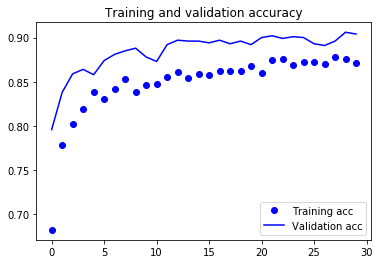

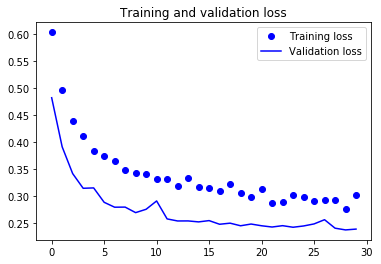

In [42]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

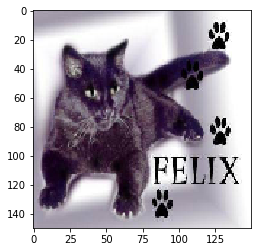

0.013491648


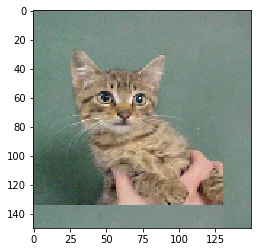

0.0039862683


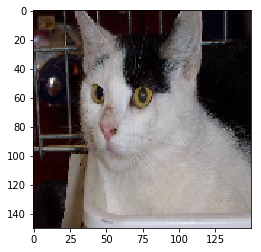

0.012911098


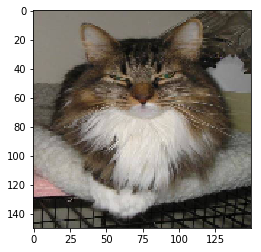

0.0012778236


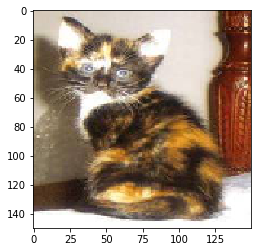

0.006598749


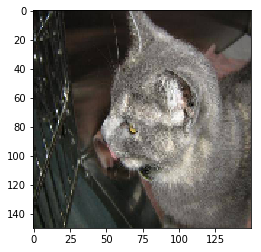

0.60936546


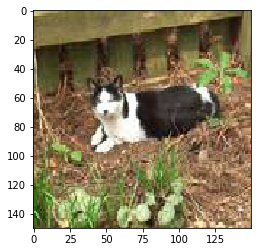

0.95676374


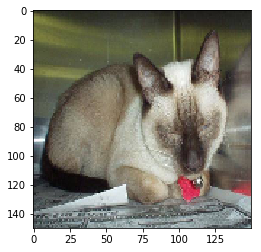

0.002780379


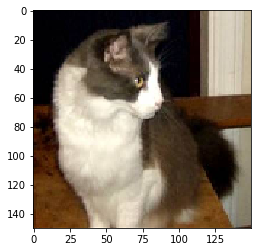

0.33967608


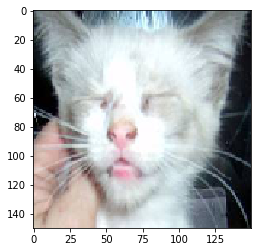

0.010583168


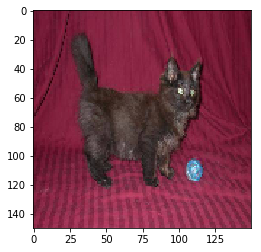

0.27475533


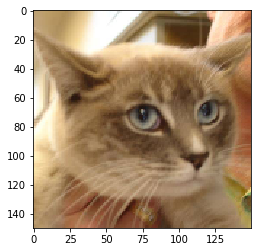

0.004293562


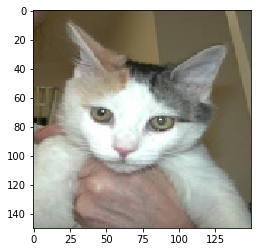

3.6842546e-05


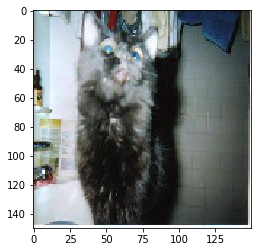

0.43800917


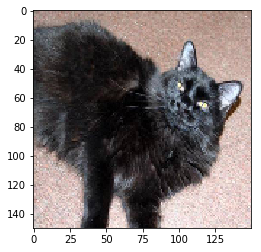

0.093164206


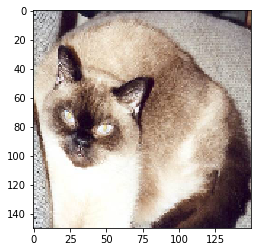

0.04799346


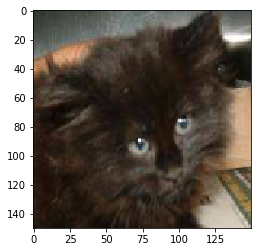

0.072443165


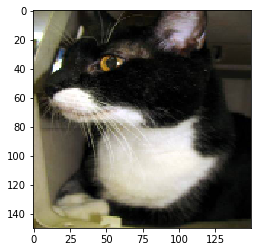

0.023723086


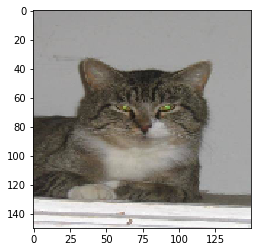

5.3804528e-05


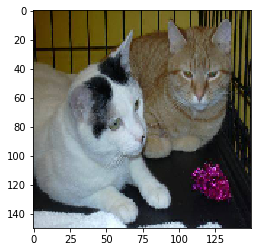

0.08430074


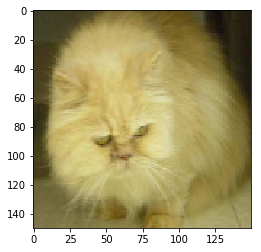

0.021839447


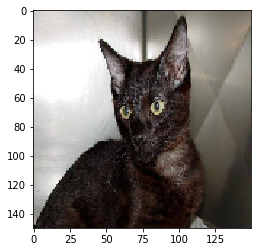

9.843131e-05


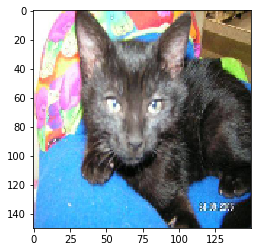

0.00044074134


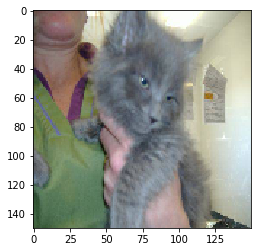

0.2035698


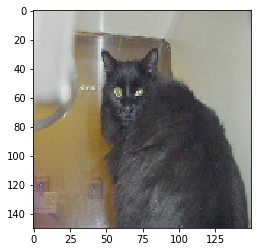

0.024199486


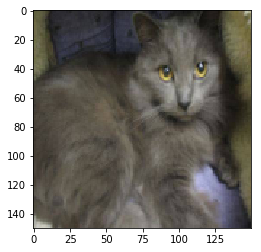

0.020034945


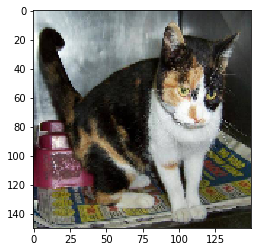

0.0048368755


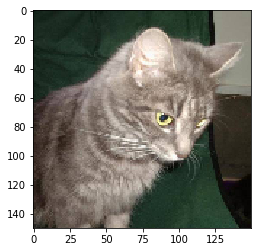

0.012623392


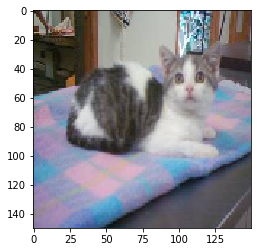

0.035370693
corrected identified count =  25


In [43]:
from keras.preprocessing import image
import numpy as np
fnames = [os.path.join(test_cats_dir, fname) for fname in os.listdir(test_cats_dir)]
count = 0
for i in range (1, 30):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.show()
    # Convert it to a Numpy array with shape (150, 150, 3)
    image_tensor = image.img_to_array(img)
    image_tensor = np.expand_dims(image_tensor,axis=0)
    image_tensor /= 255.
    prob = model.predict(image_tensor)[0][0]
    print(prob)
    if (prob < 0.3) :
        count = count + 1
print("corrected identified count = ", count)    

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

In [44]:
import keras
keras.__version__
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [45]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [46]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#base_dir = '/content/clouderizer/enhancecnn_enhance_20190731/code/cats_and_dogs_small'
base_dir = '/content/CNN_Enhancement_20190806/cats_and_dogs_small'
#base_dir = './cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [47]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 294s 3s/step - loss: 0.5679 - acc: 0.6980 - val_loss: 0.3670 - val_acc: 0.8620
Epoch 2/100
100/100 [==============================] - 288s 3s/step - loss: 0.3928 - acc: 0.8180 - val_loss: 0.3471 - val_acc: 0.8590
Epoch 3/100
100/100 [==============================] - 297s 3s/step - loss: 0.3206 - acc: 0.8610 - val_loss: 0.2318 - val_acc: 0.8980
Epoch 4/100
100/100 [==============================] - 637s 6s/step - loss: 0.2968 - acc: 0.8705 - val_loss: 0.2136 - val_acc: 0.9120
Epoch 5/100
100/100 [==============================] - 283s 3s/step - loss: 0.2804 - acc: 0.8855 - val_loss: 0.2031 - val_acc: 0.9130
Epoch 6/100
100/100 [==============================] - 306s 3s/step - loss: 0.2522 - acc: 0.8935 - val_loss: 0.2019 - val_acc: 0.9180
Epoch 7/100
100/100 [==============================] - 314s 3s/step - loss: 0.2336 - acc: 0.9035 - val_loss: 0.1989 - val_acc: 0.9120
Epoch 8/100
100/100 [==============================] - 334s 3s

In [ ]:
model.save('Using_VGG_Pretrain_Base_FineTune_20190731.h5')

Let's plot our results using the same plotting code as before:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

In [ ]:
from keras.preprocessing import image
import numpy as np
fnames = [os.path.join(test_cats_dir, fname) for fname in os.listdir(test_cats_dir)]
count = 0
for i in range (1, 30):
    img_path = fnames[i]
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.show()
    # Convert it to a Numpy array with shape (150, 150, 3)
    image_tensor = image.img_to_array(img)
    image_tensor = np.expand_dims(image_tensor,axis=0)
    image_tensor /= 255.
    prob = model.predict(image_tensor)[0][0]
    print(prob)
    if (prob < 0.3) :
        count = count + 1
print("corrected identified count = ", count)    